## **환경 설정**

In [2]:
#빅쿼리 접속
from google.oauth2 import service_account
from google.cloud import bigquery
credential_path = ""
credentials = service_account.Credentials.from_service_account_file(credential_path)
client = bigquery.Client(credentials=credentials, project='road-traffic-safety-388112')

#시각화 라이브러리 호출
import csv
import pandas as pd
import folium
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import json

#한글 설치
import os
if not os.name == 'posix':
    plt.rc("font", family="Malgun Gothic")

## **시각화 함수 외**

In [24]:
#그래프 함수
def draw_bar_chart(list_x, list_y, chart_title, color_list = '#003f7d'):
    plt.bar(list_x, list_y, color = color_list)
    plt.title(chart_title)
    plt.xticks(list_x, rotation = 45, ha = 'right')
    plt.show()
    
def draw_line_chart(list_x, list_y, chart_title, label_name = 'None', color_list ='#003f7d' ):
    plt.plot(list_x, list_y, marker='o', markersize=5, label = label_name, color = color_list)
    plt.legend()
    plt.xticks(rotation = 45, ha = 'right')
    plt.title(chart_title)
    plt.show()
    
def draw_pie_chart(list_x, list_y, chart_title, color_list = '#003f7d'):
    plt.pie(list_y, labels=list_x, autopct='%.1f%%', colors = color_list)
    plt.title(chart_title)
    plt.show()
    
#쿼리 실행 함수
def execute_query(query):
    go_query = query

    job = client.query(go_query)
    result = job.result()
    return result

## **가설 검증**

### **1. 가시거리가 짧아지면 사고 치사율이 올라갈 것이다**

#### p.10 기상조건별 총 교통사고 건수 (2022년)

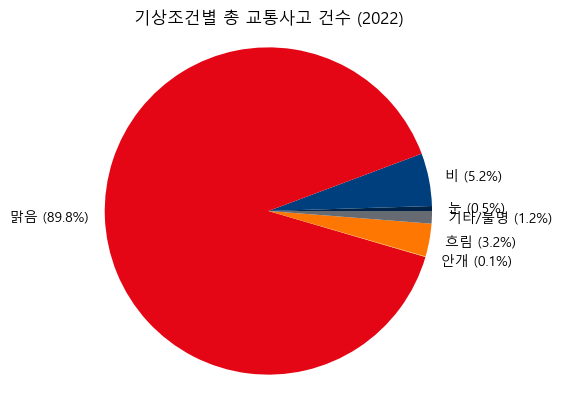

In [34]:
target_year = "2022"

query = f"""
SELECT
  weather AS Weather_Condition,
  SUM(counts) AS Total,
  SUM(death_toll) AS Death_Toll,
  SUM(serious_injury) AS Serious_Injury,
  SUM(minor_injury) AS Minor_Injury,
  SUM(injury_report) AS Injury_Report
FROM `road-traffic-safety-388112.Traffic_Accidents.Weather`
WHERE years = {target_year}
GROUP BY weather;
"""

job = client.query(query)
result = job.result()

weather_condition = []
total_count = []
death_toll = []
serious_injury = []
minor_injury = []
injury_report = []

for weather, total, death, serious, minor, report in result:
    weather_condition.append(weather)
    total_count.append(total)
    death_toll.append(death)
    serious_injury.append(serious)
    minor_injury.append(minor)
    injury_report.append(report)


fig, ax = plt.subplots(figsize=(8, 6))
total = sum(total_count)

labels = [f"{weather} ({count/total*100:.1f}%)" for weather, count in zip(weather_condition, total_count)]
colors = ['#002347', '#003f7d', '#e40615', '#f8be31', '#fd7702', '#666a73']

wedges = ax.pie(total_count, labels=labels, autopct='', colors=colors, startangle=0)
ax.set_title(f'기상조건별 총 교통사고 건수 ({target_year})')

ax.axis('equal')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.7)

#### p.10 날씨 조건에 따른 사고 발생 비중 (2022년)

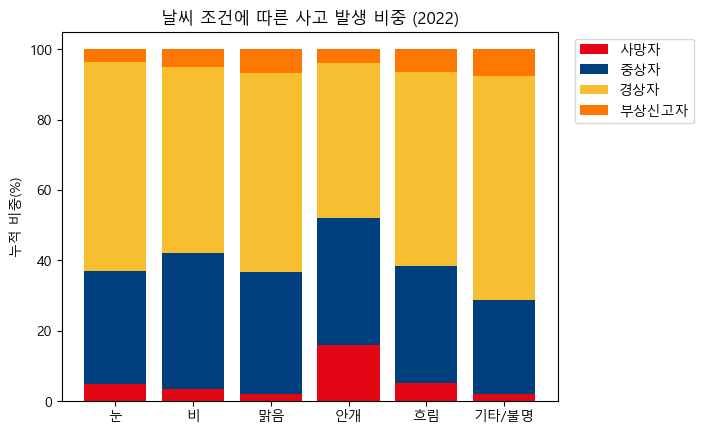

In [36]:
query = f"""
SELECT
  weather AS Weather_Condition,
  SUM(Death_Toll) AS Death_Toll,
  SUM(Serious_Injury) AS Serious_Injury,
  SUM(Minor_Injury) AS Minor_Injury,
  SUM(Injury_Report) AS Injury_Report
FROM `road-traffic-safety-388112.Traffic_Accidents.Weather`
WHERE years = {target_year}
GROUP BY weather;
"""

job = client.query(query)
results = job.result()

weather_conditions = []
death_rate = []
serious_rate = []
minor_rate = []
report_rate = []

for row in results:
    weather = row['Weather_Condition']
    death_toll = row['Death_Toll']
    serious_injury = row['Serious_Injury']
    minor_injury = row['Minor_Injury']
    injury_report = row['Injury_Report']
    total = death_toll + serious_injury + minor_injury + injury_report

    weather_conditions.append(weather)
    death_rate.append((death_toll / total) * 100)
    serious_rate.append((serious_injury / total) * 100)
    minor_rate.append((minor_injury / total) * 100)
    report_rate.append((injury_report / total) * 100)

x = range(len(weather_conditions))

plt.bar(x, death_rate, label='사망자', color='#e40615' )
plt.bar(x, serious_rate, bottom=death_rate, label='중상자', color='#003f7d')
plt.bar(x, minor_rate, bottom=[death_rate[i] + serious_rate[i] for i in x], label='경상자', color='#f8be31')
plt.bar(x, report_rate, bottom=[death_rate[i] + serious_rate[i] + minor_rate[i] for i in x], label='부상신고자', color='#fd7702')

plt.ylabel('누적 비중(%)')
plt.title(f'날씨 조건에 따른 사고 발생 비중 ({target_year})')
plt.xticks(x, weather_conditions)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

#### p.10 각 날씨별 사망률(사상자 대비 사상자 비율) (2022년)

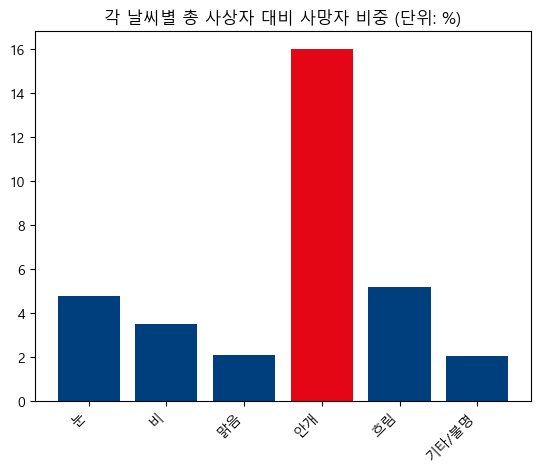

In [8]:
#쿼리 요청 및 결과
weather_query = f"""
SELECT
  weather AS Weather_Condition,
  SUM(counts) AS Total,
  SUM(death_toll) AS Death_Toll,
  SUM(serious_injury) AS Serious_Injury,
  SUM(minor_injury) AS Minor_Injury,
  SUM(injury_report) AS Injury_Report
FROM `Traffic_Accidents.Weather`
WHERE years = 2022
GROUP BY weather;
"""

weather_condition = []
total_count = []
death_toll = []
serious_injury = []
minor_injury = []
injury_report = []

for weather, total, death, serious, minor, report in execute_query(weather_query):
    weather_condition.append(weather)
    total_count.append(total)
    death_toll.append(death)
    serious_injury.append(serious)
    minor_injury.append(minor)
    injury_report.append(report)

#변수 선언
death_rate = [] #사망률
serious_rate = [] #중상률
minor_rate = [] #경상률
report_rate = [] #타박상 확률

death = 0
serious = 0
minor = 0
report = 0

Sum = 0

#비중 계산
for i in range(len(total_count)):
    Sum = death_toll[i] + serious_injury[i] + minor_injury[i] + injury_report[i]

    death = (death_toll[i]/Sum)*100 #같은 인덱스는 같은 칼럼이므로 인덱스로 바로 조회 및 계산
    serious = (serious_injury[i]/Sum)*100
    minor = (minor_injury[i]/Sum)*100
    report = (injury_report[i]/Sum)*100
    
    death_rate.append(death)
    serious_rate.append(serious)
    minor_rate.append(minor)
    report_rate.append(report)

colors = ['#003f7d','#003f7d','#003f7d','#E40615','#003f7d','#003f7d']
draw_bar_chart(weather_condition, death_rate, chart_title = "각 날씨별 총 사상자 대비 사망자 비중 (단위: %)", color_list = colors)

#### p.11 시간대별 사망자 수 (2022년, 서울)

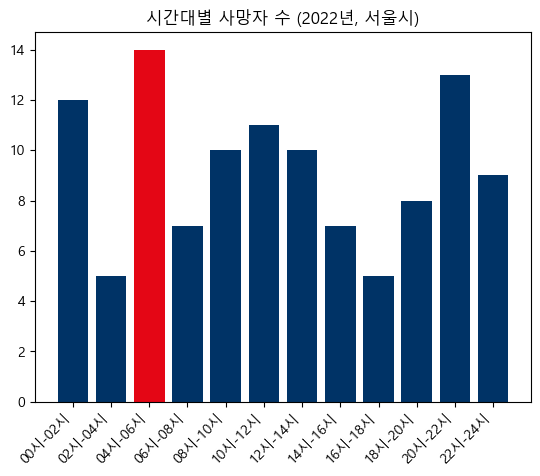

In [44]:
target_year = '2022'

by_year_query = f"""
SELECT
  hours,
  SUM(counts) AS total,
  SUM(death_toll) AS death_toll,
  SUM(serious_injury) AS serious_injury,
  SUM(minor_injury) AS minor_injury,
  SUM(injury_report) AS injury_report
FROM `Traffic_Accidents.Pedestrian_Hours_Seoul`
WHERE years = {target_year}
GROUP BY hours
ORDER BY hours;
"""

hour_list = []
total_list = []
death_list = []
serious_list = []
minor_list = []
report_list = []

for hour, total, death, serious, minor, report in execute_query(by_year_query):
    hour_list.append(hour)
    total_list.append(total)
    death_list.append(death)
    serious_list.append(serious)
    minor_list.append(minor)
    report_list.append(report)

colors = ['#003366', '#003366', '#E40615', '#003366', '#003366', '#003366', '#003366', '#003366', '#003366', '#003366']
draw_bar_chart(hour_list, death_list, chart_title = f"시간대별 사망자 수 ({target_year}년, 서울시)", color_list=colors)

#### p.11 시간대별 치사율 (2022년, 서울시)

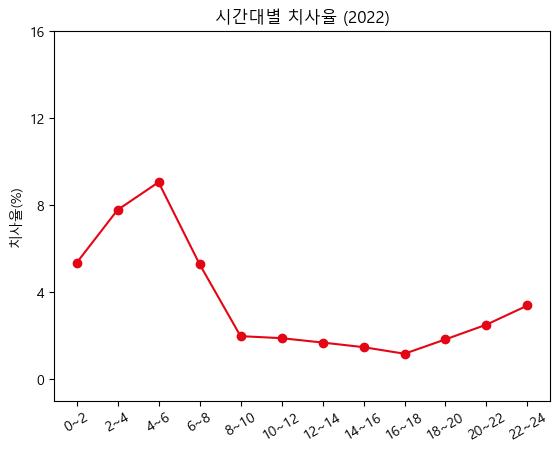

In [42]:
query = """
SELECT years,
        CASE
            WHEN hours IN ('0시~2시') THEN '0~2'
            WHEN hours IN ('2시~4시') THEN '2~4'
            WHEN hours IN ('4시~6시') THEN '4~6'
            WHEN hours IN ('6시~8시') THEN '6~8'
            WHEN hours IN ('8시~10시') THEN '8~10'
            WHEN hours IN ('10시~12시') THEN '10~12'
            WHEN hours IN ('12시~14시') THEN '12~14'
            WHEN hours IN ('14시~16시') THEN '14~16'
            WHEN hours IN ('16시~18시') THEN '16~18'
            WHEN hours IN ('18시~20시') THEN '18~20'
            WHEN hours IN ('20시~22시') THEN '20~22'
            WHEN hours IN ('22시~24시') THEN '22~24'
            ELSE hours
        END AS hour_category,
        SUM(counts) AS total_counts,
        SUM(death_toll) AS total_death_toll,
        SUM(serious_injury) AS total_serious_injury,
        SUM(minor_injury) AS total_minor_injury,
        SUM(injury_report) AS total_injury_report,
        SUM(death_toll) / SUM(counts) * 100 AS ratio_death_count
FROM `road-traffic-safety-388112.Traffic_Accidents.Driver_Hour`
GROUP BY years, hour_category
"""

# 쿼리 실행
query_job = client.query(query)

# 결과 가져오기
results = query_job.result()

years = [2022]
hour_categories = []
ratio_death_counts = []
for row in results:
    years.append(row.years)
    hour_categories.append(row.hour_category)
    ratio_death_counts.append(row.ratio_death_count)

year_mask = [y == 2022 for y in years]
year_hour_categories = [hour_categories[j] for j in range(len(hour_categories)) if year_mask[j]]
year_ratio_death_counts = [ratio_death_counts[j] for j in range(len(ratio_death_counts)) if year_mask[j]]

fig, ax = plt.subplots()

ax.plot(year_hour_categories, year_ratio_death_counts, marker='o', color='#e40615')

ax.set_ylabel('치사율(%)')
ax.set_title('시간대별 치사율 (2022)')
ax.set_xticks(range(len(year_hour_categories)))
ax.set_xticklabels(year_hour_categories, rotation=30)
ax.set_ylim([-1, 16])
ax.set_yticks(range(0, 17, 4))

plt.show()

### **2. 차량 속도가 빠를 수록 사망 사고가 많이 일어날 것이다**

#### p.12 서울 주요도로 시간대별 평균 속도

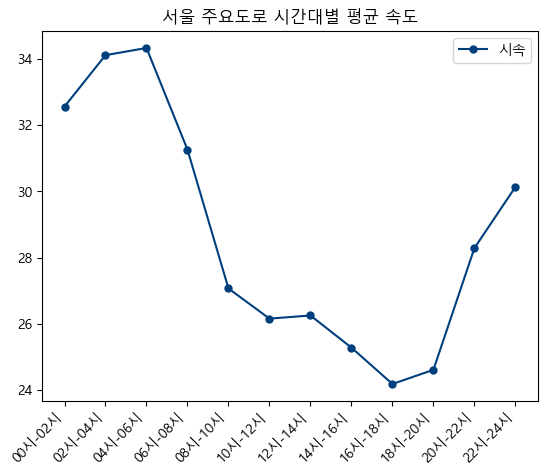

In [25]:
avg_query = f"""
SELECT 
(AVG(time1)+AVG(time2))/2 AS timeline1,
(AVG(time3)+AVG(time4))/2 AS timeline2,
(AVG(time5)+AVG(time6))/2 AS timeline3,
(AVG(time7)+AVG(time8))/2 AS timeline4,
(AVG(time9)+AVG(time10))/2 AS timeline5,
(AVG(time11)+AVG(time12))/2 AS timeline6,
(AVG(time13)+AVG(time14))/2 AS timeline7,
(AVG(time15)+AVG(time16))/2 AS timeline8,
(AVG(time17)+AVG(time18))/2 AS timeline9,
(AVG(time19)+AVG(time20))/2 AS timeline10,
(AVG(time21)+AVG(time22))/2 AS timeline11,
(AVG(time23)+AVG(time24))/2 AS timeline12
FROM `road-traffic-safety-388112.Traffic_Accidents.Seoul_speed2022`
WHERE REGEXP_CONTAINS(road_name,r'도산대로|의사당대로|서초대로|강남대로|시흥대로|공항대로|세종대로|송파대로|마포대로|반포대로|사평대로|방화대로|한강대로|영동대로|동작대로|천호대로|양재대로|삼일대로|위례성대로|강동대로|가양대로|국회대로|한남대로|여의대로|녹사평대로')
"""

x_times = ["00시-02시","02시-04시","04시-06시","06시-08시","08시-10시","10시-12시","12시-14시","14시-16시","16시-18시","18시-20시","20시-22시","22시-24시"]
y_speed_avg = []
for row in execute_query(avg_query):
    for avg_speed in row:
        y_speed_avg.append(avg_speed)

draw_line_chart(x_times, y_speed_avg, label_name="시속", chart_title = "서울 주요도로 시간대별 평균 속도")

#### p.12 서울 주요도로 시간대별 최고 속도

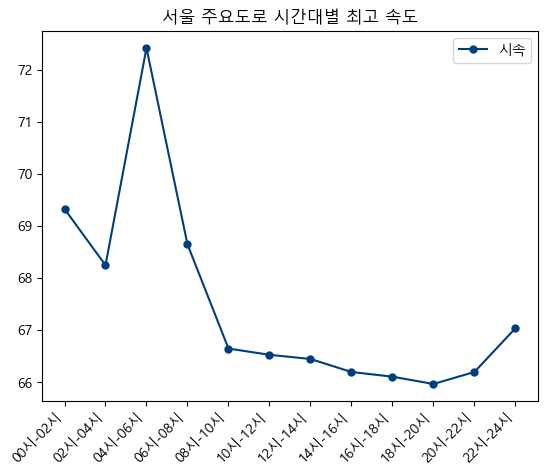

In [27]:
speed_query = f"""
SELECT
  MAX(GREATEST(time1,time2)) AS timeline1,
  MAX(GREATEST(time3,time4)) AS timeline2,
  MAX(GREATEST(time5,time6)) AS timeline3,
  MAX(GREATEST(time7,time8)) AS timeline4,
  MAX(GREATEST(time9,time10)) AS timeline5,
  MAX(GREATEST(time11,time12)) AS timeline6,
  MAX(GREATEST(time13,time14)) AS timeline7,
  MAX(GREATEST(time15,time16)) AS timeline8,
  MAX(GREATEST(time17,time18)) AS timeline9,
  MAX(GREATEST(time19,time20)) AS timeline10,
  MAX(GREATEST(time21,time22)) AS timeline11,
  MAX(GREATEST(time23,time24)) AS timeline12
FROM `road-traffic-safety-388112.Traffic_Accidents.Seoul_speed2022`
WHERE REGEXP_CONTAINS(road_name,r'도산대로|의사당대로|서초대로|강남대로|시흥대로|공항대로|세종대로|송파대로|마포대로|반포대로|사평대로|방화대로|한강대로|영동대로|동작대로|천호대로|양재대로|삼일대로|위례성대로|강동대로|가양대로|국회대로|한남대로|여의대로|녹사평대로')
"""

x_times = ["00시-02시","02시-04시","04시-06시","06시-08시","08시-10시","10시-12시","12시-14시","14시-16시","16시-18시","18시-20시","20시-22시","22시-24시"]
y_speed_max = []
for row in execute_query(speed_query):
    for max_speed in row:
        y_speed_max.append(max_speed)

draw_line_chart(x_times, y_speed_max, label_name="시속", chart_title = "서울 주요도로 시간대별 최고 속도")

#### p.12 시간대별 보행자 사망자 수 (2022년, 서울)

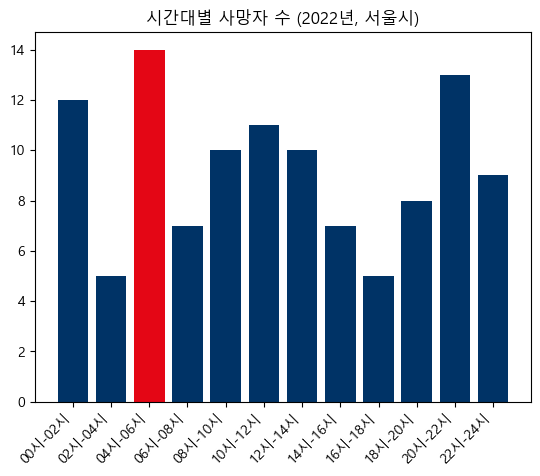

In [45]:
target_year = '2022'

by_year_query = f"""
SELECT
  hours,
  SUM(counts) AS total,
  SUM(death_toll) AS death_toll,
  SUM(serious_injury) AS serious_injury,
  SUM(minor_injury) AS minor_injury,
  SUM(injury_report) AS injury_report
FROM `Traffic_Accidents.Pedestrian_Hours_Seoul`
WHERE years = {target_year}
GROUP BY hours
ORDER BY hours;
"""

hour_list = []
total_list = []
death_list = []
serious_list = []
minor_list = []
report_list = []

for hour, total, death, serious, minor, report in execute_query(by_year_query):
    hour_list.append(hour)
    total_list.append(total)
    death_list.append(death)
    serious_list.append(serious)
    minor_list.append(minor)
    report_list.append(report)

colors = ['#003366', '#003366', '#E40615', '#003366', '#003366', '#003366', '#003366', '#003366', '#003366', '#003366']
draw_bar_chart(hour_list, death_list, chart_title = f"시간대별 사망자 수 ({target_year}년, 서울시)", color_list=colors)

### **2-2. 과속 단속 카메라가 많을수록 사망사고가 적게 일어날 것이다.**

#### p.13 서울시 각 구별 단속 카메라 분포

In [51]:
map_query = f"""
SELECT Camera_location2023.gu,
       camera_counts,
       accidents_counts,
       ROUND((accidents_counts/ camera_counts), 3) AS camera_death_percent
FROM (
SELECT gungu,
         COUNT(gungu) AS accidents_counts
  FROM `Traffic_Accidents.Death_Accidents`
  WHERE (sido = '서울')
    AND dates >= DATE('2021-01-01')
    AND dates <= DATE('2021-12-31')
  GROUP BY gungu
) AS Death_Accidents
JOIN (
SELECT gu,
         COUNT(gu) AS camera_counts
  FROM `road-traffic-safety-388112.Traffic_Accidents.Camera_location2023`
  GROUP BY gu
) AS Camera_location2023
ON Camera_location2023.gu = Death_Accidents.gungu
"""
job = client.query(map_query) # API request 
result = job.result()

map_list = []
for row in result:
    gungu_text, camera_counts, accidents_counts, camera_death_percent = row
    map_list.append([gungu_text, camera_counts, accidents_counts, camera_death_percent])
# print("for문 순회 완료")
print(map_list)

with open("./data/seoul_camera1_death.csv", "w", newline="", encoding="utf-8-sig") as fw:
    writer = csv.writer(fw)
    writer.writerow(["구", "카메라 수", "사망사고 수", "카메라대비 사망률"])
    writer.writerows(map_list)


file_path = './data/seoul_camera1_death.csv'
df = pd.read_csv(file_path, index_col="구")
df.columns = df.columns.map(str)

geo_path = "./data/seoul_municipalities_geo.json"

try:
    geo_data = json.load(open(geo_path, encoding="utf-8"))
except:
    geo_data = json.load(open(geo_path, encoding="utf-8-sig"))

g_map = folium.Map(location=[37.5665, 126.9780], tiles="Stamen Terrain", zoom_start=9)

col = "카메라 수"

folium.Choropleth(geo_data=geo_data,
                  data=df[col],
                  columns=[df.index, df[col]],
                  fill_color='YlOrRd',
                  fill_opacity=0.7,
                  line_opacity=0.3,
                  key_on='feature.properties.SIG_KOR_NM'
                  ).add_to(g_map)

g_map

[['중구', 16, 2, 0.125], ['강남구', 18, 6, 0.333], ['강동구', 27, 7, 0.259], ['강북구', 5, 5, 1.0], ['강서구', 18, 7, 0.389], ['관악구', 24, 5, 0.208], ['광진구', 17, 2, 0.118], ['구로구', 20, 1, 0.05], ['금천구', 11, 6, 0.545], ['노원구', 11, 2, 0.182], ['도봉구', 16, 1, 0.063], ['동작구', 28, 8, 0.286], ['마포구', 23, 6, 0.261], ['서초구', 71, 5, 0.07], ['성동구', 9, 5, 0.556], ['성북구', 10, 4, 0.4], ['송파구', 25, 3, 0.12], ['양천구', 13, 7, 0.538], ['용산구', 20, 2, 0.1], ['은평구', 18, 2, 0.111], ['종로구', 12, 4, 0.333], ['중랑구', 4, 6, 1.5], ['동대문구', 20, 11, 0.55], ['서대문구', 22, 3, 0.136], ['영등포구', 27, 9, 0.333]]


#### p.13 과속 단속 카메라 1대당 사망자 분포

In [58]:
map_query = f"""
SELECT Camera_location2023.gu,
	camera_counts,
	accidents_counts,
ROUND((accidents_counts/ camera_counts), 3) AS camera_death_percent
FROM (
SELECT gungu,
COUNT(gungu) AS accidents_counts
FROM `Traffic_Accidents.Death_Accidents`
WHERE (sido = '서울')
AND dates >= DATE('2021-01-01')
AND dates <= DATE('2021-12-31')
GROUP BY gungu
) AS Death_Accidents
JOIN (
SELECT gu,
COUNT(gu) AS camera_counts
FROM `road-traffic-safety-388112.Traffic_Accidents.Camera_location2023`
GROUP BY gu
) AS Camera_location2023
ON Camera_location2023.gu = Death_Accidents.gungu
"""
job = client.query(map_query)
result = job.result()

map_list = []
for row in result:
    gungu_text, camera_counts, accidents_counts, camera_death_percent = row
    map_list.append([gungu_text, camera_counts, accidents_counts, camera_death_percent])

# print("for문 순회 완료")

print(map_list)

with open("./data/seoul_camera1_death.csv", "w", newline="", encoding="utf-8-sig") as fw:
    writer = csv.writer(fw)
    writer.writerow(["구", "카메라 수", "사망사고 수", "카메라대비 사망률"])
    writer.writerows(map_list)

import pandas as pd
import folium
import json

file_path = './data/seoul_camera1_death.csv'
df = pd.read_csv(file_path, index_col="구")
df.columns = df.columns.map(str)

geo_path = "./data/seoul_municipalities_geo.json"

try:
    geo_data = json.load(open(geo_path, encoding="utf-8"))
except:
    geo_data = json.load(open(geo_path, encoding="utf-8-sig"))

g_map = folium.Map(location=[37.5665, 126.9780], tiles="Stamen Terrain", zoom_start=9)

col = "카메라대비 사망률"

folium.Choropleth(geo_data=geo_data,
data=df[col],
columns=[df.index, df[col]],
fill_color='YlOrRd',
fill_opacity=0.7,
line_opacity=0.3,
key_on='feature.properties.SIG_KOR_NM'
).add_to(g_map)

g_map

[['중구', 16, 2, 0.125], ['강남구', 18, 6, 0.333], ['강동구', 27, 7, 0.259], ['강북구', 5, 5, 1.0], ['강서구', 18, 7, 0.389], ['관악구', 24, 5, 0.208], ['광진구', 17, 2, 0.118], ['구로구', 20, 1, 0.05], ['금천구', 11, 6, 0.545], ['노원구', 11, 2, 0.182], ['도봉구', 16, 1, 0.063], ['동작구', 28, 8, 0.286], ['마포구', 23, 6, 0.261], ['서초구', 71, 5, 0.07], ['성동구', 9, 5, 0.556], ['성북구', 10, 4, 0.4], ['송파구', 25, 3, 0.12], ['양천구', 13, 7, 0.538], ['용산구', 20, 2, 0.1], ['은평구', 18, 2, 0.111], ['종로구', 12, 4, 0.333], ['중랑구', 4, 6, 1.5], ['동대문구', 20, 11, 0.55], ['서대문구', 22, 3, 0.136], ['영등포구', 27, 9, 0.333]]


### **3. 인구 수가 많을 수록 사망 사고도 많이 일어날 것이다.**

#### p.14 서울시 25개 구 인구수

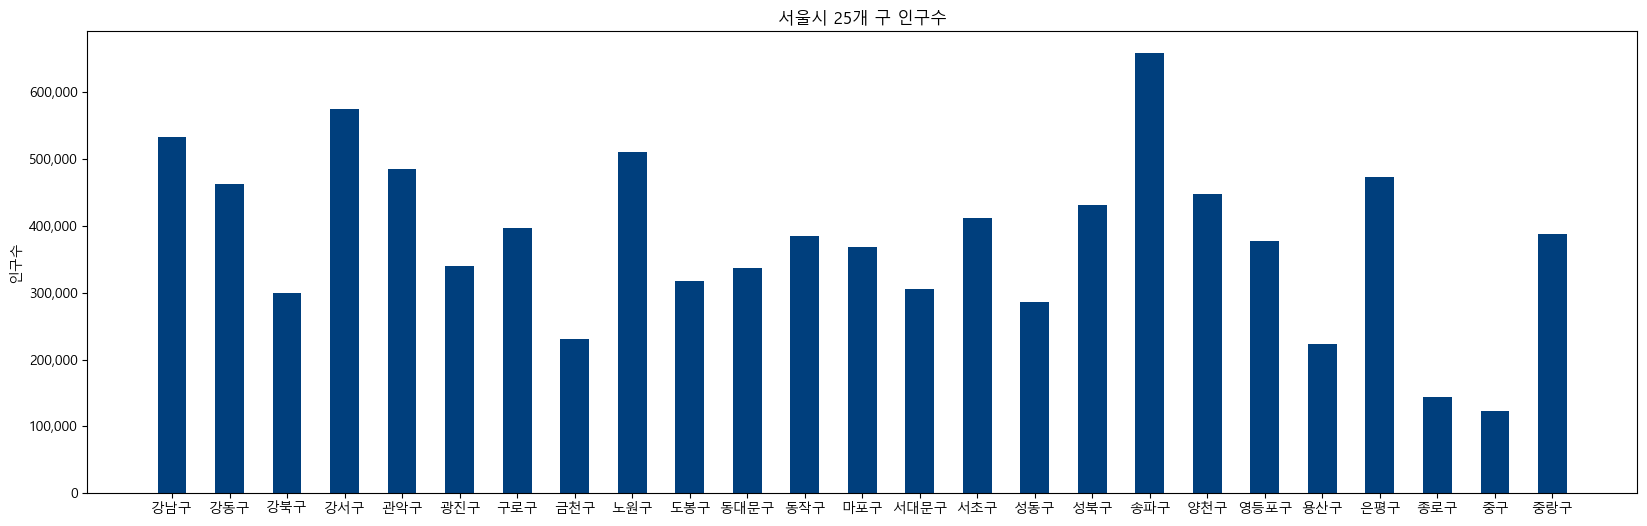

In [54]:
query = f"""
SELECT gu,
total
FROM `road-traffic-safety-388112.Traffic_Accidents.seoul_people2021`
ORDER BY gu
"""
query_job = client.query(query)

results = query_job.result()

result = []

for row in results:
    result.append(row)

x_gu = []
y_people = []

for row in result:
    gu, people = row
    x_gu.append(gu)
    y_people.append(people)

plt.figure(figsize=(20, 6))

color = (0, 0.247, 0.49)
plt.bar(x_gu, y_people, width=0.5, color=color)

plt.ylabel('인구수')

def comma_format(x, pos):
    return "{:,.0f}".format(x)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(comma_format))


plt.title("서울시 25개 구 인구수")
plt.show()

#### p.14 서울시 25개 구 사망자 수

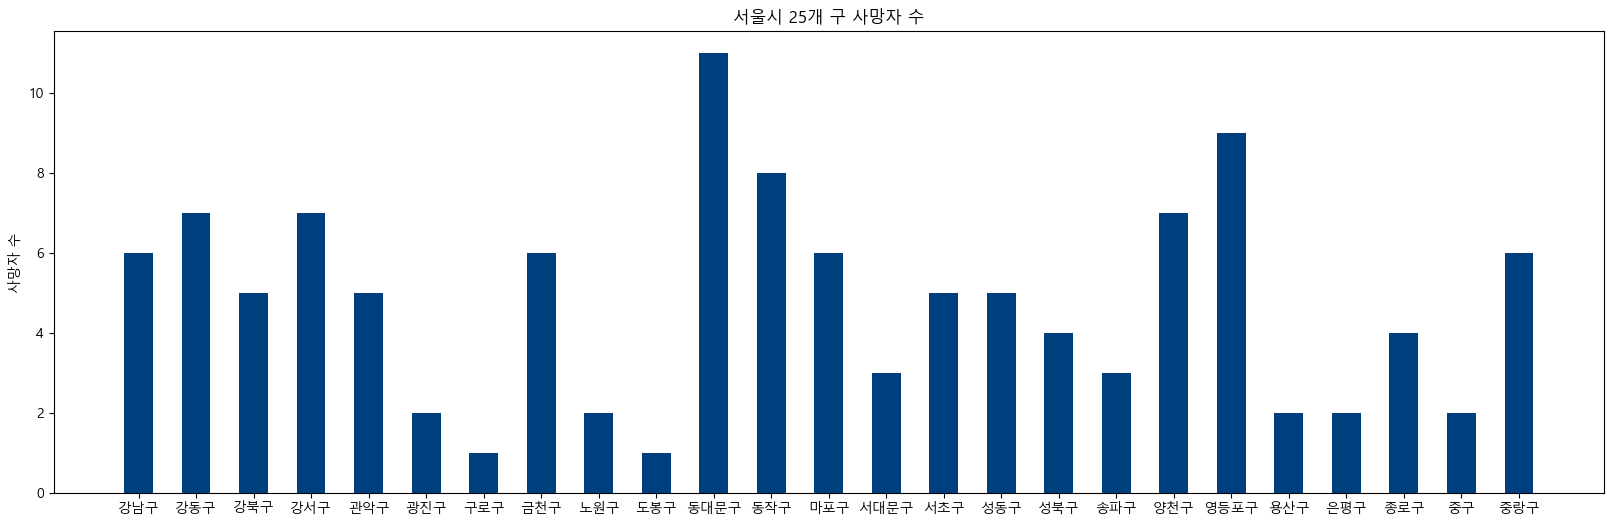

In [55]:
query = f"""
SELECT gungu,
COUNT(gungu) AS accidents_counts
FROM `Traffic_Accidents.Death_Accidents`
WHERE (sido = '서울') AND dates >= DATE('2021-01-01') AND dates <= DATE('2021-12-31')
GROUP BY gungu
ORDER BY gungu
"""
query_job = client.query(query)
results = query_job.result()

result = []

for row in results:
    result.append(row)

x_gu = []
y_count = []

for row in result:
    gu, count = row
    x_gu.append(gu)
    y_count.append(count)

plt.figure(figsize=(20, 6))

color = (0, 0.247, 0.49)
# plt.plot(x_gu, y_count, color=color)
plt.bar(x_gu, y_count, width=0.5, color=color)


plt.ylabel('사망자 수')
plt.title("서울시 25개 구 사망자 수")
plt.show()

#### p.14 인구수 대비 사망자 분포 지도

In [56]:
map_query = f"""
SELECT people2021.gu,
       accidents_counts,
       people2021.total,
       (accidents_counts/ people2021.total)  AS peole_accidents_percent
FROM (
SELECT gungu,
         COUNT(gungu) AS accidents_counts
  FROM `Traffic_Accidents.Death_Accidents`
  WHERE (sido = '서울')
    AND dates >= DATE('2021-01-01')
    AND dates <= DATE('2021-12-31')
  GROUP BY gungu
) AS Death_Accidents
JOIN (
SELECT gu, total
  FROM `road-traffic-safety-388112.Traffic_Accidents.seoul_people2021`
WHERE gu != "서울특별시"
) AS people2021
ON people2021.gu = Death_Accidents.gungu
"""
job = client.query(map_query)
result = job.result()

map_list = []
for row in result:
    gungu_text,accidents_counts, people, people_accidents_percent = row
    map_list.append([gungu_text,accidents_counts, people, people_accidents_percent])

with open("./data/seoul_people.csv", "w", newline="", encoding="utf-8-sig") as fw:
    writer = csv.writer(fw)
    writer.writerow(["구", "사망사고 수", "인구수", "인구수대비 사고수 퍼센트"])
    writer.writerows(map_list)

file_path = './data/seoul_people.csv'
df = pd.read_csv(file_path, index_col="구")
df.columns = df.columns.map(str)

geo_path = "./data/seoul_municipalities_geo.json"

try:
    geo_data = json.load(open(geo_path, encoding="utf-8"))
except:
    geo_data = json.load(open(geo_path, encoding="utf-8-sig"))

g_map = folium.Map(location=[37.5665, 126.9780], tiles="Stamen Terrain", zoom_start=9)

col = "인구수대비 사고수 퍼센트"

folium.Choropleth(geo_data=geo_data,
                  data=df[col],
                  columns=[df.index, df[col]],
                  fill_color='YlOrRd',
                  fill_opacity=0.7,
                  line_opacity=0.3,
                  key_on='feature.properties.SIG_KOR_NM'
                  ).add_to(g_map)

g_map